In [ ]:
# Import library utama
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from PIL import Image

# Library untuk preprocessing data
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Library untuk membangun model CNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array

# Library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Path ke folder dataset utama
dataset_path = Path(r"D:\KULIAH\asalamualaikum\daun_cabai_full")
classes = os.listdir(dataset_path)

In [3]:

# Data Augmentation untuk dataset training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisasi gambar
    rotation_range=30,  # Rotasi gambar
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Distorsi bentuk
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip horizontal
    fill_mode="nearest"  # Cara mengisi pixel kosong
)
print('Augmentasi data untuk training selesai dibuat')

# Preprocessing untuk dataset validation dan testing (tidak menggunakan augmentasi data)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
print('Rescaling untuk tresting selesai dibuat')

# Preprocessing untuk dataset validation dan testing (tidak menggunakan augmentasi data)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
print('Rescaling untuk validation selesai dibuat')

Augmentasi data untuk training selesai dibuat
Rescaling untuk tresting selesai dibuat
Rescaling untuk validation selesai dibuat


In [4]:
# Model DenseNet121
# ukuran gambar untuk Dense121
height_densenet = 224
width_densenet = 224
size_densenet = 32  # Ukuran batch

train_generator3 = train_datagen.flow_from_directory(
    directory="D:/KULIAH/asalamualaikum/dataset_split/train",
    color_mode="rgb",
    target_size=(height_densenet, width_densenet),  # Pastikan sesuai dengan kebutuhan model
    class_mode="categorical",
    batch_size=size_densenet,
    shuffle=True,
    seed=42
)

validation_generator3 = val_datagen.flow_from_directory(
    directory="D:/KULIAH/asalamualaikum/dataset_split/validation",
    color_mode="rgb",
    target_size=(height_densenet, width_densenet),  # Pastikan sesuai dengan kebutuhan model
    class_mode="categorical",
    batch_size=size_densenet,
    shuffle=False,
    seed=42
)


test_generator3 = test_datagen.flow_from_directory(
    directory="D:/KULIAH/asalamualaikum/dataset_split/test",
    color_mode="rgb",
    target_size=(height_densenet, width_densenet),  # Pastikan sesuai dengan kebutuhan model
    class_mode="categorical",
    batch_size=size_densenet,
    shuffle=False,
    seed=42
)

# Menampilkan label kelas
class_names = list(train_generator3.class_indices.keys())
print(f"Class labels: {train_generator3.class_indices}")

Found 224 images belonging to 4 classes.


Found 56 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Class labels: {'daun_bercak': 0, 'daun_gemini': 1, 'daun_layu': 2, 'daun_sehat': 3}


In [5]:
# Load DenseNet121 dengan pre-trained weights di ImageNet
base_model_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(height_densenet, width_densenet, 3))
num_classes = len(class_names)

# Freeze layer agar tidak dilatih ulang
base_model_densenet.trainable = False

# Tambahkan lapisan custom
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk mengurangi dimensi
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

# Gabungkan model
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Kompilasi model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [35]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Training DenseNet
history_densenet = model_densenet.fit(
    train_generator3,
    validation_data=validation_generator3,
    epochs=30,
    steps_per_epoch=train_generator3.samples // size_densenet,
    validation_steps=validation_generator3.samples // size_densenet,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
7/7 [==============================] - 33s 3s/step - loss: 2.0598 - accuracy: 0.3616 - val_loss: 1.0992 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - 20s 3s/step - loss: 1.0738 - accuracy: 0.5312 - val_loss: 0.9924 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - 19s 3s/step - loss: 0.8742 - accuracy: 0.6473 - val_loss: 0.8235 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - 18s 3s/step - loss: 0.7104 - accuracy: 0.7277 - val_loss: 0.8754 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 18s 3s/step - loss: 0.5854 - accuracy: 0.7545 - val_loss: 0.6938 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/30
7/7 [==============================] - 18s 3s/step - loss: 0.5368 - accuracy: 0.7723 - val_loss: 0.8544 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 7/30
7/7 [==============================] - 18s 3s/step - loss: 0.4811 - accuracy: 0.812

In [40]:
# Evaluasi pada test set
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator3)
print(f"Test Accuracy: {test_acc_densenet:.2f}")

4/4 [==============================] - 7s 1s/step - loss: 0.6311 - accuracy: 0.7667
Test Accuracy: 0.77


In [50]:
import tensorflow as tf

# Ubah sebagian layer DenseNet121 menjadi trainable
base_model_densenet.trainable = True

# Pilih layer tertentu untuk di fine-tune
fine_tune_at = 300  # Mulai melatih ulang dari layer ke-300

for layer in base_model_densenet.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model dengan learning rate lebih rendah
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Latih ulang model
history_finetune_densenet = model_densenet.fit(
    train_generator3,
    validation_data=test_generator3,
    epochs=20,  # Tambahkan beberapa epoch untuk fine-tuning
    steps_per_epoch=train_generator3.samples // size_densenet,
    validation_steps=test_generator3.samples // size_densenet,
    verbose=1
)

Epoch 1/20
7/7 [==============================] - 41s 4s/step - loss: 0.1513 - accuracy: 0.9643 - val_loss: 0.7270 - val_accuracy: 0.7917
Epoch 2/20
7/7 [==============================] - 24s 3s/step - loss: 0.0952 - accuracy: 0.9643 - val_loss: 0.6115 - val_accuracy: 0.8750
Epoch 3/20
7/7 [==============================] - 25s 3s/step - loss: 0.0762 - accuracy: 0.9777 - val_loss: 0.5999 - val_accuracy: 0.8750
Epoch 4/20
7/7 [==============================] - 24s 3s/step - loss: 0.0680 - accuracy: 0.9866 - val_loss: 0.5911 - val_accuracy: 0.8646
Epoch 5/20
7/7 [==============================] - 25s 3s/step - loss: 0.0580 - accuracy: 0.9911 - val_loss: 0.6415 - val_accuracy: 0.8646
Epoch 6/20
7/7 [==============================] - 27s 4s/step - loss: 0.0464 - accuracy: 0.9821 - val_loss: 0.6254 - val_accuracy: 0.8854
Epoch 7/20
7/7 [==============================] - 25s 3s/step - loss: 0.0540 - accuracy: 0.9777 - val_loss: 0.5882 - val_accuracy: 0.8750
Epoch 8/20
7/7 [==================

In [51]:
# Evaluasi pada test set
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator3)
print(f"Test Accuracy: {test_acc_densenet:.2f}")

4/4 [==============================] - 7s 1s/step - loss: 0.6012 - accuracy: 0.9083
Test Accuracy: 0.91


In [53]:
model_densenet.save("model_densenet.h5")
print("Model berhasil disimpan")

Model berhasil disimpan


4/4 [==============================] - 8s 2s/step - loss: 0.6012 - accuracy: 0.9083
Test Inception Loss: 0.6012, Test Inception Accuracy: 0.9083


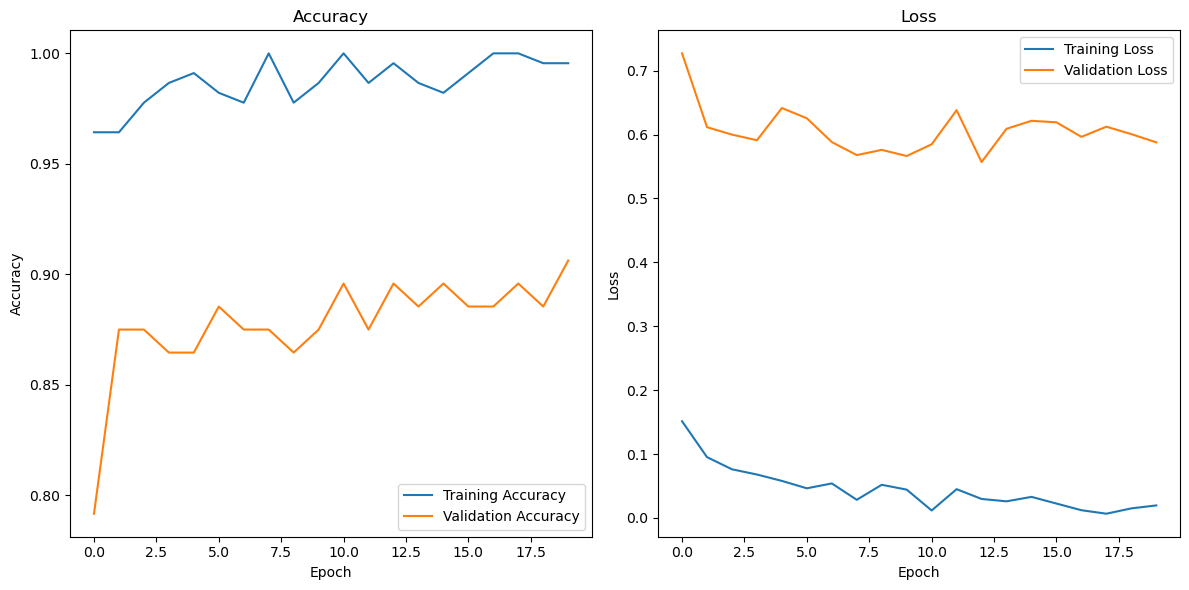

In [54]:
# Grafik plot
# Evaluasi pada test data
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator3)
print(f"Test Inception Loss: {test_loss_densenet:.4f}, Test Inception Accuracy: {test_acc_densenet:.4f}")

# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_finetune_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune_densenet.history['loss'], label='Training Loss')
plt.plot(history_finetune_densenet.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


4/4 [==============================] - 10s 1s/step


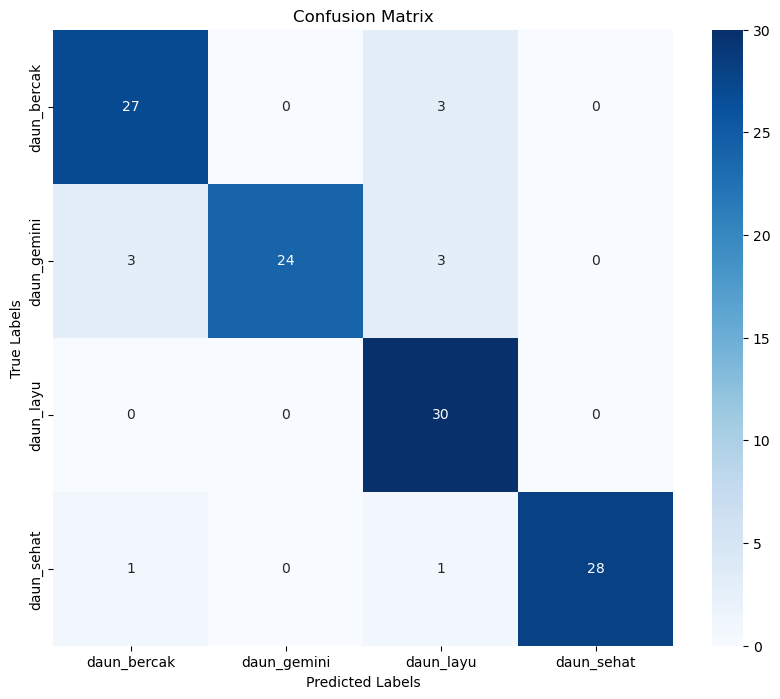

Classification Report:
              precision    recall  f1-score   support

 daun_bercak       0.87      0.90      0.89        30
 daun_gemini       1.00      0.80      0.89        30
   daun_layu       0.81      1.00      0.90        30
  daun_sehat       1.00      0.93      0.97        30

    accuracy                           0.91       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.91      0.91       120



In [55]:
# Langkah 1: Prediksi pada Test Data
Y_pred = model_densenet.predict(test_generator3)
y_pred_classes = np.argmax(Y_pred, axis=1)  # Konversi prediksi ke label kelas
y_true = test_generator3.classes  # Label sebenarnya

# Langkah 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Langkah 3: Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)


1/1 [==============================] - 3s 3s/step


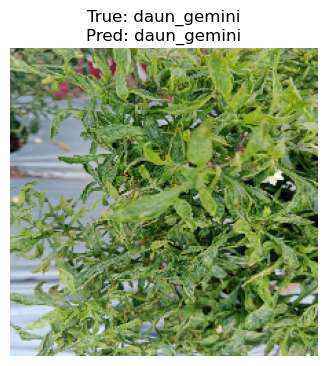

1/1 [==============================] - 0s 76ms/step


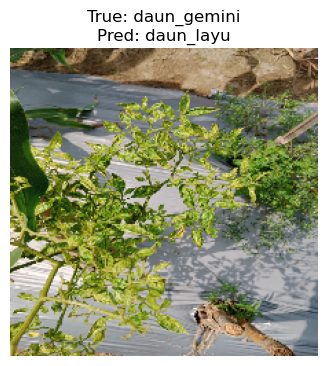

1/1 [==============================] - 0s 155ms/step


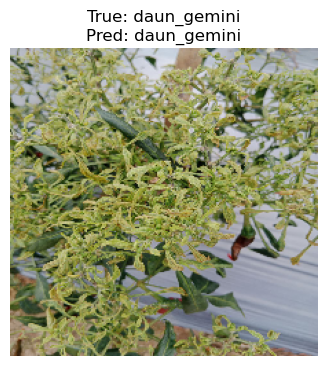

1/1 [==============================] - 0s 68ms/step


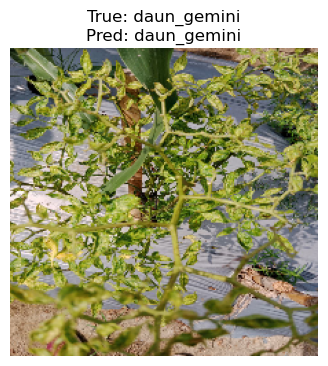

1/1 [==============================] - 0s 100ms/step


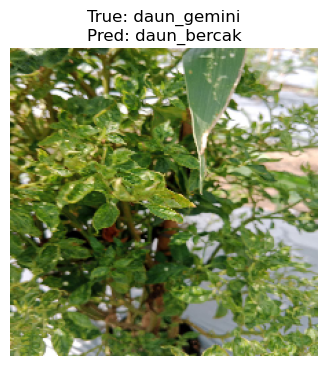

1/1 [==============================] - 0s 66ms/step


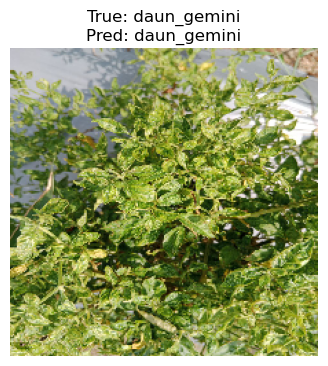

1/1 [==============================] - 0s 70ms/step


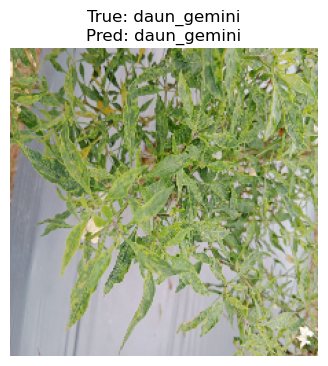

1/1 [==============================] - 0s 79ms/step


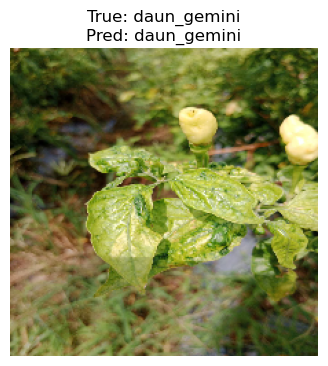

1/1 [==============================] - 0s 65ms/step


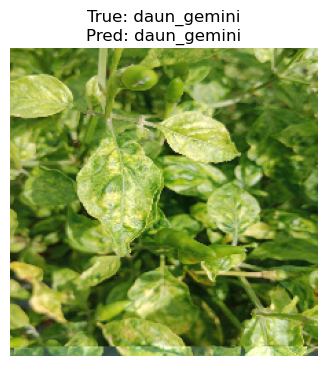

1/1 [==============================] - 0s 69ms/step


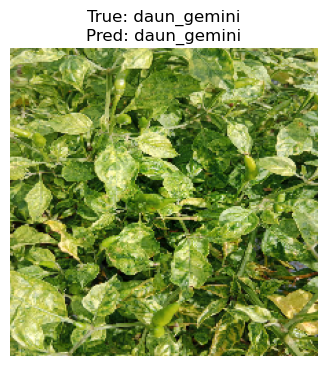

1/1 [==============================] - 0s 63ms/step


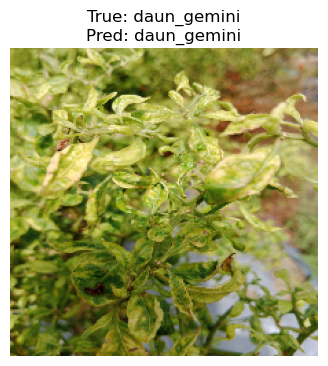

1/1 [==============================] - 0s 95ms/step


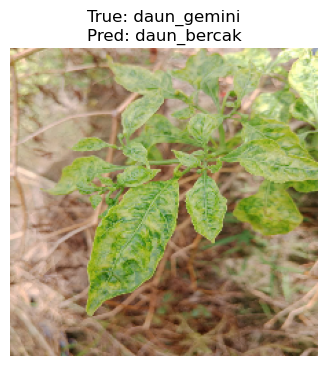

1/1 [==============================] - 0s 58ms/step


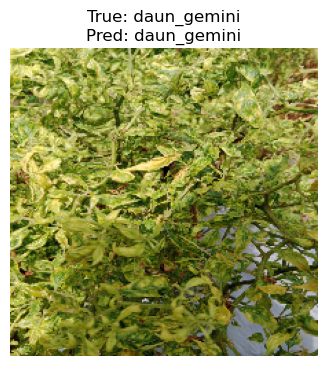

1/1 [==============================] - 0s 74ms/step


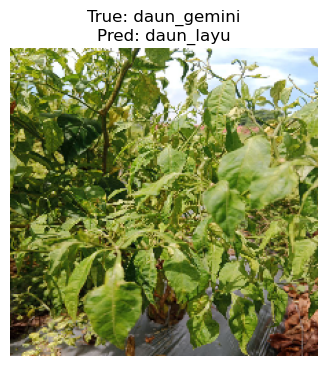

1/1 [==============================] - 0s 103ms/step


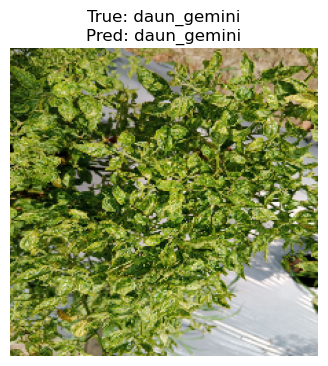

1/1 [==============================] - 0s 74ms/step


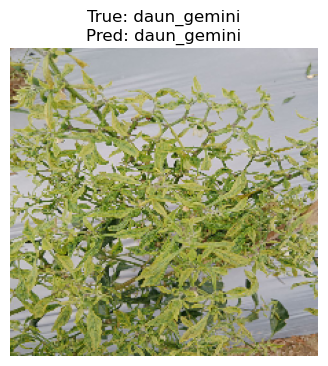

1/1 [==============================] - 0s 79ms/step


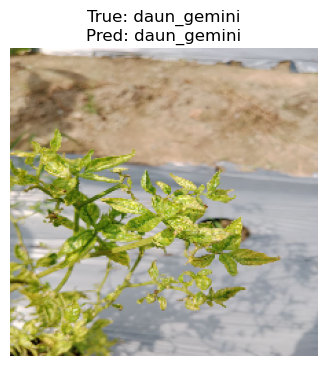

1/1 [==============================] - 0s 77ms/step


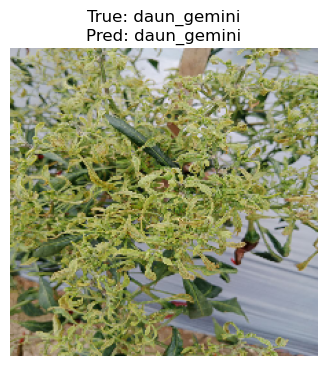

1/1 [==============================] - 0s 80ms/step


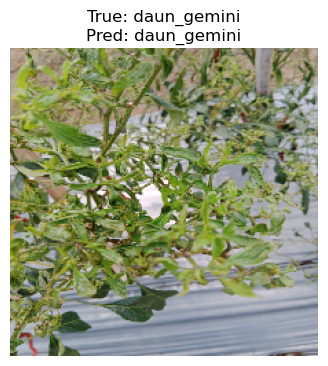

1/1 [==============================] - 0s 73ms/step


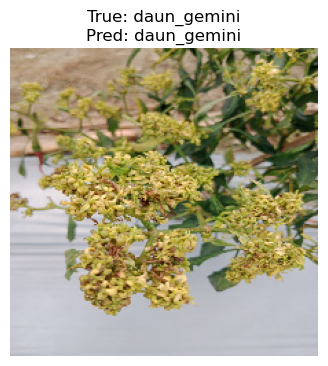

In [57]:
# Validasi prediksi pada 10 gambar pertama dari test_generator
test_images, test_labels = next(test_generator3)

for i in range(20):  # Cek 20 gambar pertama
    img = test_images[i]
    true_class_index = np.argmax(test_labels[i])
    true_class_name = class_names[true_class_index]

    # Prediksi model
    prediction = model_densenet.predict(img.reshape(1, 224, 224, 3))
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]

    # Visualisasi
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"True: {true_class_name}\nPred: {predicted_class_name}")
    plt.axis('off')
    plt.show()


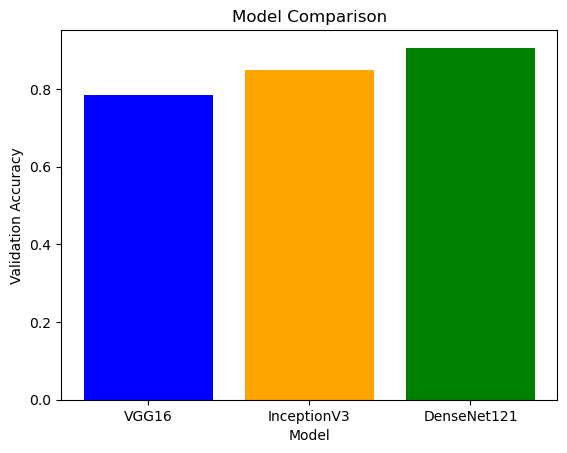

In [112]:
# 6. Model Comparison
model_names = ["VGG16", "InceptionV3", "DenseNet121"]
accuracies = [history_finevgg16.history['val_accuracy'][-1],
              history_fine_inception.history['val_accuracy'][-1], 
              history_finetune_densenet.history['val_accuracy'][-1]]

plt.bar(model_names, accuracies, color=['blue','orange', 'green'])
plt.title("Model Comparison")
plt.ylabel("Validation Accuracy")
plt.xlabel("Model")
plt.show()

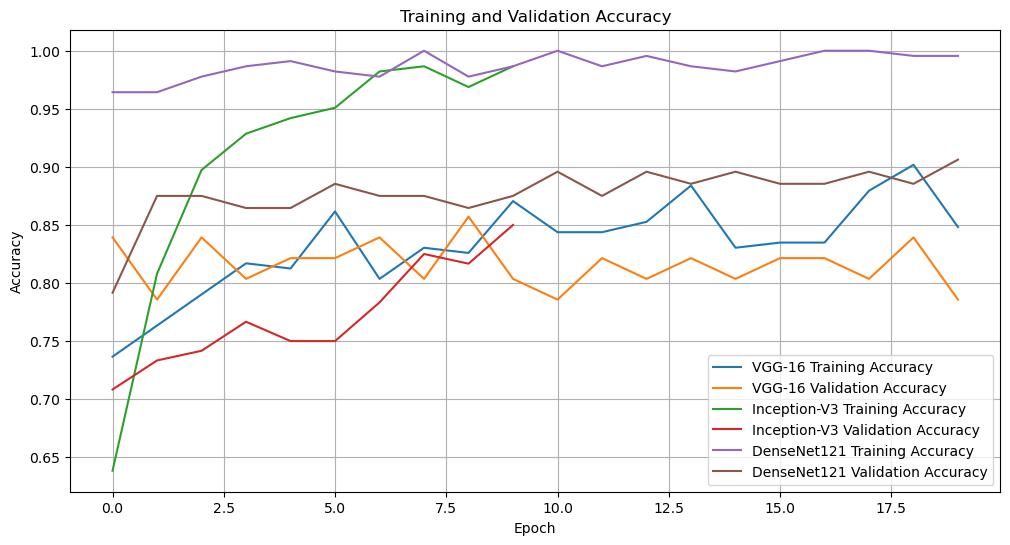

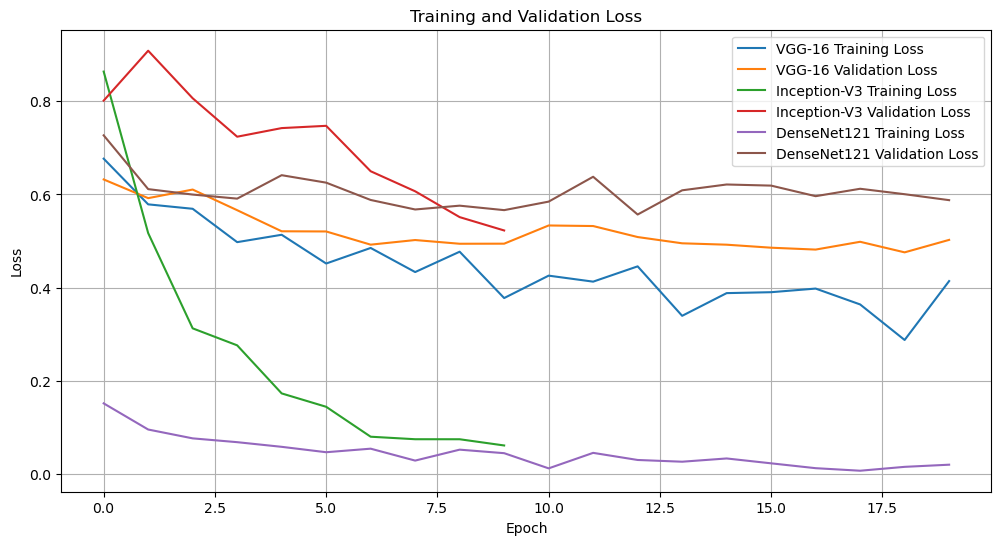

In [110]:
# Perbandingan 3 model

# Ambil data dari history
history_vgg = history_finevgg16.history  # History dari model VGG-16
history_inception = history_fine_inception.history  # History dari model Inception-V3
history_densenet = history_finetune_densenet.history  # History dari model DenseNet121

# Plot akurasi
plt.figure(figsize=(12, 6))
plt.plot(history_vgg['accuracy'], label='VGG-16 Training Accuracy')
plt.plot(history_vgg['val_accuracy'], label='VGG-16 Validation Accuracy')
plt.plot(history_inception['accuracy'], label='Inception-V3 Training Accuracy')
plt.plot(history_inception['val_accuracy'], label='Inception-V3 Validation Accuracy')
plt.plot(history_densenet['accuracy'], label='DenseNet121 Training Accuracy')
plt.plot(history_densenet['val_accuracy'], label='DenseNet121 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_vgg['loss'], label='VGG-16 Training Loss')
plt.plot(history_vgg['val_loss'], label='VGG-16 Validation Loss')
plt.plot(history_inception['loss'], label='Inception-V3 Training Loss')
plt.plot(history_inception['val_loss'], label='Inception-V3 Validation Loss')
plt.plot(history_densenet['loss'], label='DenseNet121 Training Loss')
plt.plot(history_densenet['val_loss'], label='DenseNet121 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [113]:
# Cari nilai terbaik untuk masing-masing model
best_vgg_accuracy = max(history_vgg['val_accuracy'])
best_vgg_loss = min(history_vgg['val_loss'])

best_inception_accuracy = max(history_inception['val_accuracy'])
best_inception_loss = min(history_inception['val_loss'])

best_densenet_accuracy = max(history_densenet['val_accuracy'])
best_densenet_loss = min(history_densenet['val_loss'])

# Tampilkan hasil
print("Model Comparison:")
print(f"VGG-16 -> Best Val Accuracy: {best_vgg_accuracy:.4f}, Best Val Loss: {best_vgg_loss:.4f}")
print(f"Inception-V3 -> Best Val Accuracy: {best_inception_accuracy:.4f}, Best Val Loss: {best_inception_loss:.4f}")
print(f"DenseNet121 -> Best Val Accuracy: {best_densenet_accuracy:.4f}, Best Val Loss: {best_densenet_loss:.4f}")


Model Comparison:
VGG-16 -> Best Val Accuracy: 0.8571, Best Val Loss: 0.4757
Inception-V3 -> Best Val Accuracy: 0.8500, Best Val Loss: 0.5227
DenseNet121 -> Best Val Accuracy: 0.9062, Best Val Loss: 0.5570


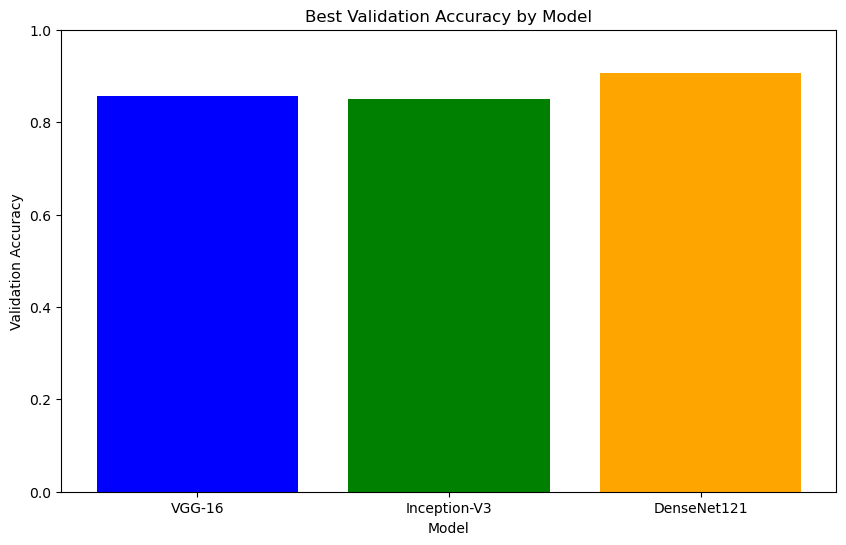

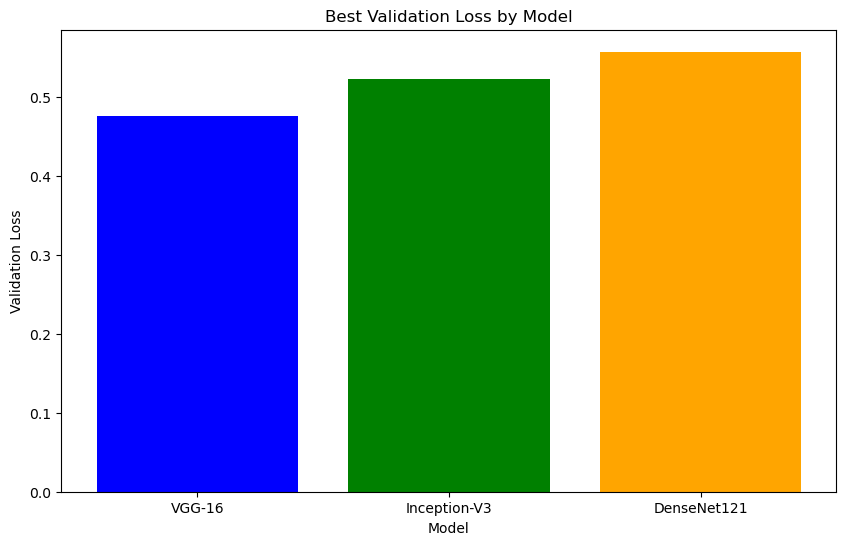

In [114]:
import matplotlib.pyplot as plt

# Data untuk setiap model
models = ['VGG-16', 'Inception-V3', 'DenseNet121']
accuracies = [best_vgg_accuracy, best_inception_accuracy, best_densenet_accuracy]
losses = [best_vgg_loss, best_inception_loss, best_densenet_loss]

# Plot Akurasi
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Best Validation Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)  # Akurasi berada dalam rentang [0, 1]
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.bar(models, losses, color=['blue', 'green', 'orange'])
plt.title('Best Validation Loss by Model')
plt.xlabel('Model')
plt.ylabel('Validation Loss')
plt.show()


In [115]:
import pandas as pd

# Simpan hasil dalam bentuk dictionary
results = {
    "Model": ["VGG-16", "Inception-V3", "DenseNet121"],
    "Best Validation Accuracy": [best_vgg_accuracy, best_inception_accuracy, best_densenet_accuracy],
    "Best Validation Loss": [best_vgg_loss, best_inception_loss, best_densenet_loss]
}

# Convert ke DataFrame untuk tampilan tabel
results_df = pd.DataFrame(results)

# Cetak hasil
print(results_df)


          Model  Best Validation Accuracy  Best Validation Loss
0        VGG-16                  0.857143              0.475720
1  Inception-V3                  0.850000              0.522732
2   DenseNet121                  0.906250              0.556975
